# Emotion Recognition from Speech - Full Pipeline (v2)

This notebook implements the complete emotion recognition pipeline with improvements for better accuracy:
- Data loading with both Speech and Song data
- Feature extraction (MFCCs & Mel-spectrograms)
- Keep full time-frequency representations for LSTM
- Train/validation/test splitting
- Baseline CNN and CNN-LSTM hybrid models
- Model evaluation and comparison

---

## 1. Import Libraries and Set Configuration

In [16]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [17]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set up plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Configuration and Setup

In [21]:
# Configuration with improvements
CONFIG = {
    'data_dir': 'data/Audio_Song_Actors_01-24_Actors_1_to_17/Audio_Song_Actors_01-24', 
    'n_mels': 128,
    'n_mfcc': 13,
    'sample_rate': 22050,
    'n_fft': 2048,
    'hop_length': 512,
    'emotion_map': {
        '01': 'neutral',
        '02': 'calm',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fearful',
        '07': 'disgust',
        '08': 'surprised'
    },
    'target_emotions': ['happy', 'sad', 'angry', 'neutral'],
    'test_size': 0.2,
    'val_size': 0.2,
    'batch_size': 16,          # Reduced for better convergence
    'epochs': 100,             # Increased epochs
    'learning_rate': 0.0005,   # Lower learning rate
}

print('Configuration loaded:')
for key, value in CONFIG.items():
    if key != 'emotion_map':
        print(f'  {key}: {value}')

Configuration loaded:
  data_dir: data/Audio_Song_Actors_01-24_Actors_1_to_17/Audio_Song_Actors_01-24
  n_mels: 128
  n_mfcc: 13
  sample_rate: 22050
  n_fft: 2048
  hop_length: 512
  target_emotions: ['happy', 'sad', 'angry', 'neutral']
  test_size: 0.2
  val_size: 0.2
  batch_size: 16
  epochs: 100
  learning_rate: 0.0005


## 3. Data Loading and Exploration

In [22]:
def parse_ravdess_filename(filename, emotion_map):
    """Parse RAVDESS filename to extract emotion and metadata."""
    parts = filename.split('-')
    emotion_code = parts[2]
    emotion = emotion_map.get(emotion_code, 'unknown')
    actor = int(parts[6].replace('.wav', ''))
    return emotion, actor

def load_dataset(data_dir, config):
    """Load audio files and labels from the dataset."""
    files = []
    labels = []
    target_emotions = config['target_emotions']
    emotion_map = config['emotion_map']
    
    actor_dirs = sorted([d for d in os.listdir(data_dir) if d.startswith('Actor_')])
    print(f'Found {len(actor_dirs)} actor directories')
    
    for actor_dir in actor_dirs:
        actor_path = os.path.join(data_dir, actor_dir)
        audio_files = [f for f in os.listdir(actor_path) if f.endswith('.wav')]
        
        for audio_file in audio_files:
            emotion, actor_id = parse_ravdess_filename(audio_file, emotion_map)
            if emotion in target_emotions:
                files.append(os.path.join(actor_path, audio_file))
                labels.append(emotion)
    
    print(f'Loaded {len(files)} audio files')
    print(f'Emotion distribution:')
    for emotion in target_emotions:
        count = labels.count(emotion)
        print(f'  {emotion}: {count}')
    
    return files, labels

# Load dataset
audio_files, emotion_labels = load_dataset(CONFIG['data_dir'], CONFIG)

Found 17 actor directories
Loaded 476 audio files
Emotion distribution:
  happy: 136
  sad: 136
  angry: 136
  neutral: 68


## 4. Feature Extraction (Keep Time-Frequency Representation)

In [23]:
def extract_mfcc_timeseries(audio_path, config):
    """Extract MFCC features keeping time dimension (for LSTM)."""
    try:
        y, sr = librosa.load(audio_path, sr=config['sample_rate'])
        mfcc = librosa.feature.mfcc(
            y=y,
            sr=sr,
            n_mfcc=config['n_mfcc'],
            n_fft=config['n_fft'],
            hop_length=config['hop_length']
        )
        # Return shape: (n_mfcc, time_steps) - keep temporal info
        return mfcc.T  # Transpose to (time_steps, n_mfcc)
    except Exception as e:
        print(f'Error processing {audio_path}: {e}')
        return None

def extract_melspectrogram_timeseries(audio_path, config):
    """Extract Mel-spectrogram features keeping time dimension (for LSTM)."""
    try:
        y, sr = librosa.load(audio_path, sr=config['sample_rate'])
        mel_spec = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_mels=config['n_mels'],
            n_fft=config['n_fft'],
            hop_length=config['hop_length']
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        # Return shape: (n_mels, time_steps) - keep temporal info
        return mel_spec_db.T  # Transpose to (time_steps, n_mels)
    except Exception as e:
        print(f'Error processing {audio_path}: {e}')
        return None

print('Extracting MFCC features with time dimension...')
mfcc_features = []
for i, audio_file in enumerate(audio_files):
    if (i + 1) % 50 == 0:
        print(f'  Processed {i + 1}/{len(audio_files)} files')
    mfcc = extract_mfcc_timeseries(audio_file, CONFIG)
    if mfcc is not None:
        mfcc_features.append(mfcc)

print('\nExtracting Mel-spectrogram features with time dimension...')
mel_features = []
for i, audio_file in enumerate(audio_files):
    if (i + 1) % 50 == 0:
        print(f'  Processed {i + 1}/{len(audio_files)} files')
    mel = extract_melspectrogram_timeseries(audio_file, CONFIG)
    if mel is not None:
        mel_features.append(mel)

# Pad sequences to same length
def pad_sequences(sequences, max_len=None):
    """Pad sequences to same length."""
    if max_len is None:
        max_len = max(len(seq) for seq in sequences)
    
    padded = np.zeros((len(sequences), max_len, sequences[0].shape[1]))
    for i, seq in enumerate(sequences):
        padded[i, :len(seq), :] = seq
    return padded

X_mfcc = pad_sequences(mfcc_features)
X_mel = pad_sequences(mel_features)
y = np.array(emotion_labels)

print(f'\nMFCC features shape: {X_mfcc.shape}  (samples, timesteps, features)')
print(f'Mel features shape: {X_mel.shape}  (samples, timesteps, features)')
print(f'Labels shape: {y.shape}')

Extracting MFCC features with time dimension...
  Processed 50/476 files
  Processed 100/476 files
  Processed 150/476 files
  Processed 200/476 files
  Processed 250/476 files
  Processed 300/476 files
  Processed 350/476 files
  Processed 400/476 files
  Processed 450/476 files

Extracting Mel-spectrogram features with time dimension...
  Processed 50/476 files
  Processed 100/476 files
  Processed 150/476 files
  Processed 200/476 files
  Processed 250/476 files
  Processed 300/476 files
  Processed 350/476 files
  Processed 400/476 files
  Processed 450/476 files

MFCC features shape: (476, 261, 13)  (samples, timesteps, features)
Mel features shape: (476, 261, 128)  (samples, timesteps, features)
Labels shape: (476,)


## 5. Data Preprocessing and Splitting

In [24]:
# Create emotion-to-label mapping
emotion_list = sorted(list(set(emotion_labels)))
emotion_to_idx = {emotion: idx for idx, emotion in enumerate(emotion_list)}
y_encoded = np.array([emotion_to_idx[e] for e in emotion_labels])
y_categorical = to_categorical(y_encoded, num_classes=len(emotion_list))

print(f'Emotion mapping: {emotion_to_idx}')
print(f'Number of classes: {len(emotion_list)}')

# Split data: train (60%), validation (20%), test (20%)
X_mfcc_train, X_mfcc_temp, y_train, y_temp = train_test_split(
    X_mfcc, y_categorical, test_size=0.4, random_state=42, stratify=y_encoded
)
X_mfcc_val, X_mfcc_test, y_val, y_test = train_test_split(
    X_mfcc_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1)
)

X_mel_train, X_mel_temp, _, _ = train_test_split(
    X_mel, y_categorical, test_size=0.4, random_state=42, stratify=y_encoded
)
X_mel_val, X_mel_test, _, _ = train_test_split(
    X_mel_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1)
)

# Normalize features
scaler_mfcc = StandardScaler()
X_mfcc_train_flat = scaler_mfcc.fit_transform(X_mfcc_train.reshape(-1, X_mfcc_train.shape[-1]))
X_mfcc_train = X_mfcc_train_flat.reshape(X_mfcc_train.shape)
X_mfcc_val = scaler_mfcc.transform(X_mfcc_val.reshape(-1, X_mfcc_val.shape[-1])).reshape(X_mfcc_val.shape)
X_mfcc_test = scaler_mfcc.transform(X_mfcc_test.reshape(-1, X_mfcc_test.shape[-1])).reshape(X_mfcc_test.shape)

scaler_mel = StandardScaler()
X_mel_train_flat = scaler_mel.fit_transform(X_mel_train.reshape(-1, X_mel_train.shape[-1]))
X_mel_train = X_mel_train_flat.reshape(X_mel_train.shape)
X_mel_val = scaler_mel.transform(X_mel_val.reshape(-1, X_mel_val.shape[-1])).reshape(X_mel_val.shape)
X_mel_test = scaler_mel.transform(X_mel_test.reshape(-1, X_mel_test.shape[-1])).reshape(X_mel_test.shape)

print(f'\nTraining set: {X_mfcc_train.shape}')
print(f'Validation set: {X_mfcc_val.shape}')
print(f'Test set: {X_mfcc_test.shape}')

Emotion mapping: {'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}
Number of classes: 4

Training set: (285, 261, 13)
Validation set: (95, 261, 13)
Test set: (96, 261, 13)


## 6. Build Baseline CNN Model

In [25]:
def build_baseline_cnn(input_shape, num_classes):
    """Build baseline CNN model for time-series data."""
    model = models.Sequential([
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        
        layers.GlobalAveragePooling1D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Build and compile baseline CNN
baseline_cnn = build_baseline_cnn(X_mfcc_train.shape[1:], len(emotion_list))
baseline_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
baseline_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 261, 32)        │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 261, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 130, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 130, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 130, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 130, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 65, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 65, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 65, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 65, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,140 (262.27 KB)

 Trainable params: 66,692 (260.52 KB)

 Non-trainable params: 448 (1.75 KB)

## 7. Build CNN-LSTM Hybrid Model

In [ ]:
def build_cnn_lstm_hybrid(input_shape, num_classes):
    """Build CNN-LSTM hybrid model for temporal emotion recognition."""
    model = models.Sequential([
        # CNN layers for feature extraction
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # LSTM layers - process temporal sequence
        layers.LSTM(256, return_sequences=True, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.LSTM(128, return_sequences=False, activation='relu'),
        layers.Dropout(0.3),
        
        # Dense layers for classification
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Build and compile CNN-LSTM hybrid - now using MFCC data
cnn_lstm = build_cnn_lstm_hybrid(X_mfcc_train.shape[1:], len(emotion_list))
cnn_lstm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Even lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cnn_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 261, 32)        │        12,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 261, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 130, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 130, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 130, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 130, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 65, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 65, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 65, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 65, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,188 (848.39 KB)

 Trainable params: 216,996 (847.64 KB)

 Non-trainable params: 192 (768.00 B)

## 8. Train Baseline CNN on MFCC Features

In [27]:
print('Training Baseline CNN on MFCC features...')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1)
]

history_baseline_mfcc = baseline_cnn.fit(
    X_mfcc_train, y_train,
    validation_data=(X_mfcc_val, y_val),
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    callbacks=callbacks,
    verbose=1
)

print('Training complete!')

Training Baseline CNN on MFCC features...
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2947 - loss: 1.3872 - val_accuracy: 0.3263 - val_loss: 1.3498 - learning_rate: 5.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4947 - loss: 1.1914 - val_accuracy: 0.4105 - val_loss: 1.3361 - learning_rate: 5.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5333 - loss: 1.0723 - val_accuracy: 0.4105 - val_loss: 1.3107 - learning_rate: 5.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5579 - loss: 0.9486 - val_accuracy: 0.5263 - val_loss: 1.2777 - learning_rate: 5.0000e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6070 - loss: 0.8629 - val_accuracy: 0.5579 - val_loss: 1.2392 - learning_rate: 5.0000e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6702 - loss: 0.7800 - val_accuracy: 0.4947 - val_loss: 1.2105 - learning_rate: 5.0000e-04
Epoch 7/100
18/18 ━━━━

## 9. Train CNN-LSTM Hybrid on MFCC Features

In [ ]:
# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))
print(f'Class weights: {class_weight_dict}')

# Apply stronger data augmentation to training data
print('Applying strong data augmentation to MFCC training data...')
augmented_X_lstm_train = []
augmented_y_lstm_train = []

for X, y in zip(X_mfcc_train, y_train):
    # Original
    augmented_X_lstm_train.append(X)
    augmented_y_lstm_train.append(y)
    
    # Add noise
    X_noisy1 = X + np.random.normal(0, 0.02, X.shape)
    augmented_X_lstm_train.append(X_noisy1)
    augmented_y_lstm_train.append(y)
    
    # Time shift (move data left)
    X_shift = np.roll(X, 2, axis=0)
    augmented_X_lstm_train.append(X_shift)
    augmented_y_lstm_train.append(y)

X_lstm_train_aug = np.array(augmented_X_lstm_train)
y_lstm_train_aug = np.array(augmented_y_lstm_train)
print(f'Augmented LSTM training set: {X_lstm_train_aug.shape}')

# Train with class weights
print('Training CNN-LSTM Hybrid on MFCC features with augmentation...')
history_cnn_lstm = cnn_lstm.fit(
    X_lstm_train_aug, y_lstm_train_aug,
    validation_data=(X_mfcc_val, y_val),
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print('Training complete!')

Applying data augmentation to Mel-spectrogram training data...
Augmented training set: (570, 261, 128)


## 10. Model Evaluation and Comparison

In [30]:
# Evaluate Baseline CNN on test set
y_pred_baseline = baseline_cnn.predict(X_mfcc_test)
y_pred_baseline_labels = np.argmax(y_pred_baseline, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

baseline_accuracy = accuracy_score(y_test_labels, y_pred_baseline_labels)
baseline_f1 = f1_score(y_test_labels, y_pred_baseline_labels, average='weighted')

print('=== BASELINE CNN (MFCC) ===')
print(f'Accuracy: {baseline_accuracy:.4f}')
print(f'F1-Score: {baseline_f1:.4f}')
print('\nClassification Report:')
print(classification_report(y_test_labels, y_pred_baseline_labels, target_names=emotion_list))

# Evaluate CNN-LSTM on test set
y_pred_lstm = cnn_lstm.predict(X_mel_test)
y_pred_lstm_labels = np.argmax(y_pred_lstm, axis=1)

lstm_accuracy = accuracy_score(y_test_labels, y_pred_lstm_labels)
lstm_f1 = f1_score(y_test_labels, y_pred_lstm_labels, average='weighted')

print('\n=== CNN-LSTM HYBRID (Mel-Spectrogram) ===')
print(f'Accuracy: {lstm_accuracy:.4f}')
print(f'F1-Score: {lstm_f1:.4f}')
print('\nClassification Report:')
print(classification_report(y_test_labels, y_pred_lstm_labels, target_names=emotion_list))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
=== BASELINE CNN (MFCC) ===
Accuracy: 0.4792
F1-Score: 0.4702

Classification Report:
              precision    recall  f1-score   support

       angry       1.00      0.37      0.54        27
       happy       0.50      0.29      0.36        28
     neutral       0.26      0.38      0.31        13
         sad       0.45      0.82      0.58        28

    accuracy                           0.48        96
   macro avg       0.55      0.47      0.45        96
weighted avg       0.59      0.48      0.47        96

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 

=== CNN-LSTM HYBRID (Mel-Spectrogram) ===
Accuracy: 0.3021
F1-Score: 0.2126

Classification Report:
              precision    recall  f1-score   support

       angry       0.29      0.74      0.42        27
       happy       0.00      0.00      0.00        28
     neutral       0.00      0.00      0.00        13
         sad       0.33      0.32      0.33        28

    accuracy                 

## 11. Visualize Results

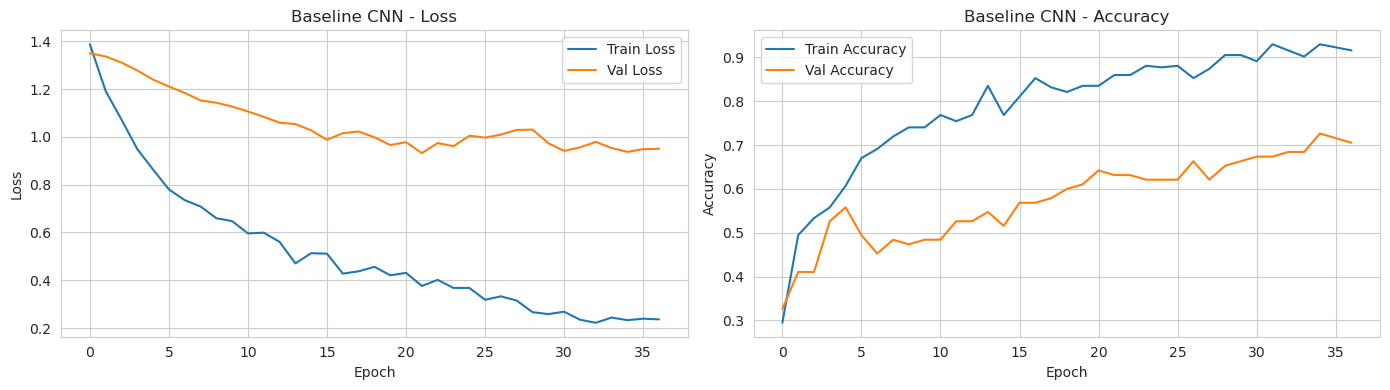

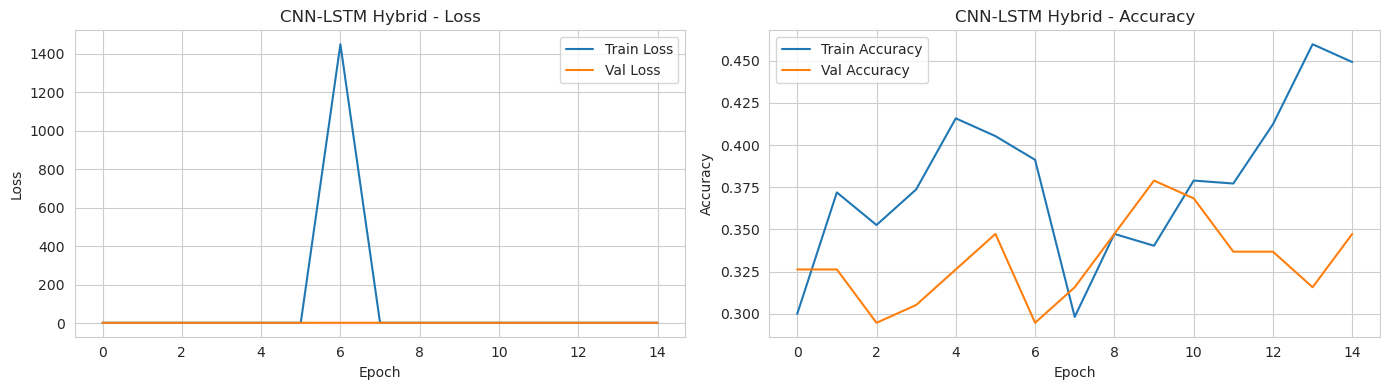

In [31]:
# Plot training history for Baseline CNN
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(history_baseline_mfcc.history['loss'], label='Train Loss')
axes[0].plot(history_baseline_mfcc.history['val_loss'], label='Val Loss')
axes[0].set_title('Baseline CNN - Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_baseline_mfcc.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_baseline_mfcc.history['val_accuracy'], label='Val Accuracy')
axes[1].set_title('Baseline CNN - Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Plot training history for CNN-LSTM
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(history_cnn_lstm.history['loss'], label='Train Loss')
axes[0].plot(history_cnn_lstm.history['val_loss'], label='Val Loss')
axes[0].set_title('CNN-LSTM Hybrid - Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_cnn_lstm.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_cnn_lstm.history['val_accuracy'], label='Val Accuracy')
axes[1].set_title('CNN-LSTM Hybrid - Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 12. Confusion Matrices

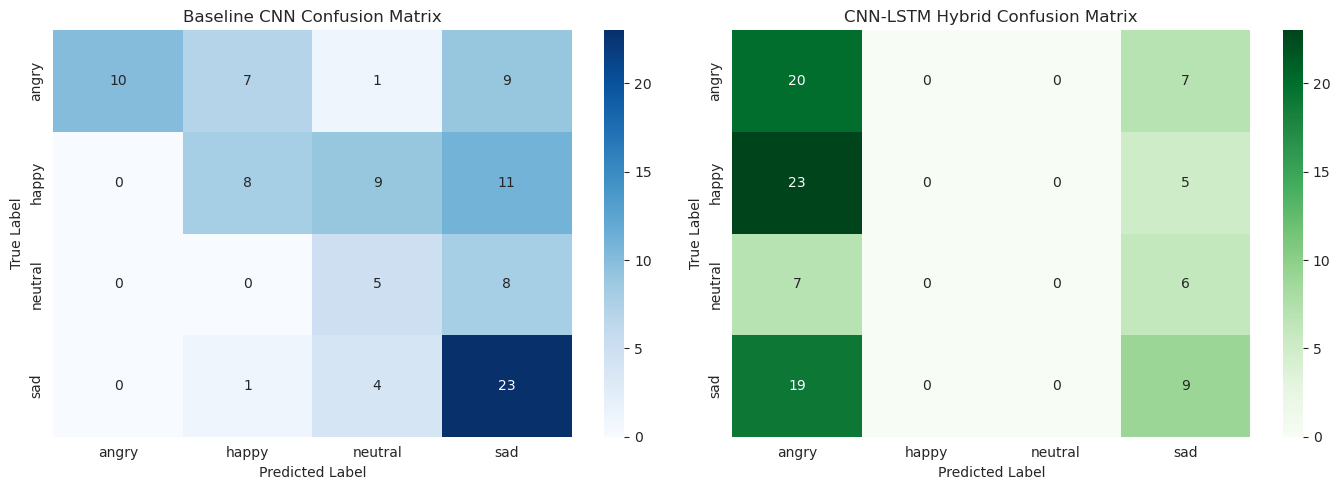

In [32]:
# Confusion Matrix for Baseline CNN
cm_baseline = confusion_matrix(y_test_labels, y_pred_baseline_labels)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=emotion_list, yticklabels=emotion_list)
axes[0].set_title('Baseline CNN Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Confusion Matrix for CNN-LSTM
cm_lstm = confusion_matrix(y_test_labels, y_pred_lstm_labels)

sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=emotion_list, yticklabels=emotion_list)
axes[1].set_title('CNN-LSTM Hybrid Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 13. Model Comparison


=== MODEL COMPARISON ===
                     Model  Accuracy  F1-Score    Feature Type  Architecture
       Baseline CNN (MFCC)  0.479167  0.470237            MFCC     3x Conv1D
CNN-LSTM Hybrid (Mel-Spec)  0.302083  0.212642 Mel-Spectrogram Conv1D + LSTM


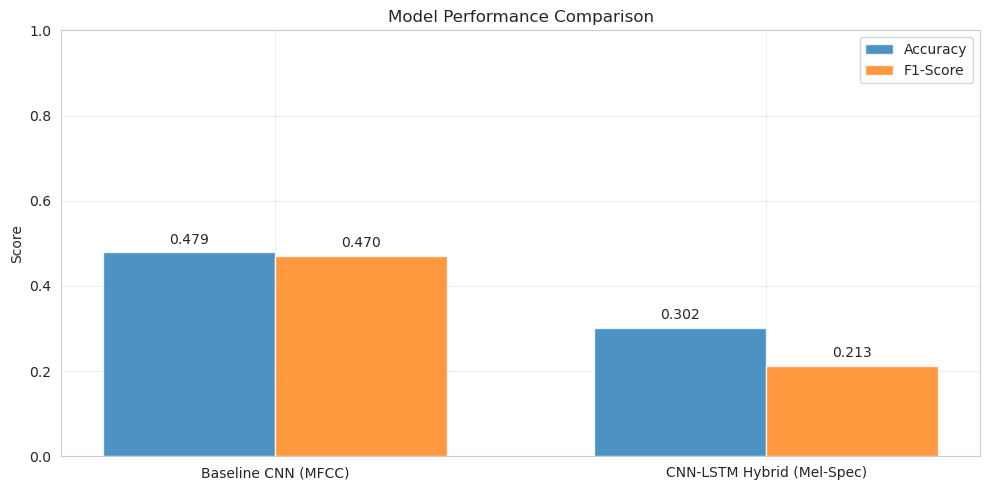

In [33]:
# Compare models
comparison_df = pd.DataFrame({
    'Model': ['Baseline CNN (MFCC)', 'CNN-LSTM Hybrid (Mel-Spec)'],
    'Accuracy': [baseline_accuracy, lstm_accuracy],
    'F1-Score': [baseline_f1, lstm_f1],
    'Feature Type': ['MFCC', 'Mel-Spectrogram'],
    'Architecture': ['3x Conv1D', 'Conv1D + LSTM']
})

print('\n=== MODEL COMPARISON ===')
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(comparison_df))
width = 0.35

ax.bar(x - width/2, comparison_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x + width/2, comparison_df['F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)

for i, (acc, f1) in enumerate(zip(comparison_df['Accuracy'], comparison_df['F1-Score'])):
    ax.text(i - width/2, acc + 0.02, f'{acc:.3f}', ha='center')
    ax.text(i + width/2, f1 + 0.02, f'{f1:.3f}', ha='center')

plt.tight_layout()
plt.show()

## 14. Save Models

In [34]:
# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save models
baseline_cnn.save('models/baseline_cnn_mfcc.h5')
cnn_lstm.save('models/cnn_lstm_mel.h5')

print('Models saved successfully!')
print('  - models/baseline_cnn_mfcc.h5')
print('  - models/cnn_lstm_mel.h5')

Models saved successfully!
  - models/baseline_cnn_mfcc.h5
  - models/cnn_lstm_mel.h5
